In [353]:
from pylab import *
colormap='Greys_r'

cmap = cm.get_cmap(colormap, 13)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import os
from astropy import units as u
from tqdm import tqdm_notebook
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.nddata import CCDData
import ccdproc as ccdp
from astropy.time import Time
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.ndimage import percentile_filter
from astropy import units

import starry
starry.config.lazy = False
starry.config.quiet = True

import warnings
warnings.filterwarnings("ignore")

COLOR='black'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9

datadir = '/Users/arcticfox/Downloads/gemini_data'

TIME = Time(np.load(os.path.join(datadir, 'mjddates.npy')), format='mjd')
barycorr = np.load(os.path.join(datadir, 'barycorr.npy')) * u.km / u.s

lines = Table.read(datadir + '_2021/fraunhofer.txt', format='ascii')

parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

In [3]:
planet_d_per = 12.403200
planet_c_per = 8.249580

planet_c_dur = (4.66*u.hour).to(u.day).value
planet_d_dur = (5.59*u.hour).to(u.day).value

planet_c_t0 = 2458846.097156# - 2400000
planet_d_t0 = 2458845.803649# - 2400000

In [4]:
fitsfiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if i.endswith('.fits')])
TIME = np.zeros(len(fitsfiles))

for i in range(len(fitsfiles)):
    hdu = fits.open(fitsfiles[i])
    TIME[i] = hdu[0].header['MJDATE']
    hdu.close()
    
len(TIME), planet_c_t0+planet_c_per*3-planet_c_dur/2

(53, 2458870.7488126666)

In [5]:
def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

In [6]:
wavefiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if 'wavelength_order_' in i and i.endswith('.npy')])
specfiles = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir)
                     if 'spectra_order_' in i and i.endswith('.npy')])
specfiles

array(['/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_03.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_04.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_10.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_11.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_15.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_18.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_21.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_25.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_26.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_27.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_28.npy',
       '/Users/arcticfox/Downloads/gemini_data/interp_1d_spectra_order_29.npy',
       '/Users/arcticfox/Downloads/gemin

In [7]:
wavelengths = {}
spectra = {}
for i in range(len(wavefiles)):
    index = int(specfiles[i].split('.')[0][-2:])
    subtab = lines[lines['index'] == index]
    wdat = np.load(wavefiles[i], allow_pickle=True)
    sdat = np.load(specfiles[i], allow_pickle=True)
    for key in subtab['line']:
        wavelengths[key] = wdat
        spectra[key] = sdat
#spectra = np.load('interp_1d_spectra.npy')

In [8]:
def subregions(location, w, offsets, offset_line, feature=None):
    global TIME
    #print(w)
    #print(np.where( (w>=location-offsets[0]) & (w<=location+offsets[1])))
    #print(offsets)
    whole_region = ((w>=location-offsets[0]) & 
                    (w<=location+offsets[1]))

    line = ((w[whole_region]>=location-offset_line[0]) & 
            (w[whole_region]<=location+offset_line[1]))

    
    if feature != 'na' and feature != 'mgb4':
        continuum = np.where((line==False))[0]
    elif feature == 'na':
        continuum = np.where( ( (w>=587.5)  & (w<=588.6) ) |
                              ( (w>=590.0)  & (w<=591) ) )[0]
    elif feature == 'mgb4':
        continuum = np.where( ( (w) ))
    
    params = {'location': location,
              'region': whole_region,
              'line': line,
              'continuum': continuum}
        
    return params

In [9]:
def measure_excess(wavelength, spectra, params, tab):
    global TIME
    
    widths = np.zeros(len(TIME))

    #wave = wavelengths[:,tab['index'],:]
    #spec = spectra[:,tab['index'],:]
    
    template_out = np.nanmedian(spectra[int(len(TIME)-7):], axis=0)[params['region']]
    
    lines = np.zeros((len(TIME), 
                      len(wavelength[0][params['region']][params['line']])))
    waves = np.zeros((len(TIME), 
                      len(wavelength[0][params['region']][params['line']])))

    for i in range(len(TIME)):

        w, f = wavelength[i][params['region']]+0.0, spectra[i][params['region']]+0.0

        ## CALCULATE EXCESS ABSORPTION
        divout = f/template_out
        mask = np.where(divout < np.nanmedian(divout)+2.5*np.nanstd(divout))[0]
        widths[i] = np.nansum((f[mask]/template_out[mask]) - 1) * -1       
        lines[i] = f[params['line']]
        waves[i] = w[params['line']]
        plt.plot(w[mask], f[mask], 'k')
        
        #plt.plot(w[mask][params['line']], f[mask][params['line']])
        
    plt.plot(w, template_out, 'w')
    plt.axvspan(w[params['line']][0], w[params['line']][-1], 
                    color='darkorange', alpha=0.3)
    #plt.axvspan(w[params['continuum']][0], w[params['continuum']][-1], 
    #                color='skyblue', alpha=0.4, zorder=1)
    plt.ylim(np.nanmin(f[mask])-0.01, 
             np.nanmax(f[mask])+0.01)
    plt.show()
    
    return widths, lines, waves

- sodium as doublet as a single feature (✓)
- Mg lines (x)
- h-beta line (x)
- FeII - 546.6 (✓)
- Li - 680.3 (✓)
- He - 587.5618

In [10]:
list(wavelengths.keys())

['caII', 'caIII', 'caI', 'Li', 'halpha', 'NaD', 'FeII', 'mgb2', 'mgb4']

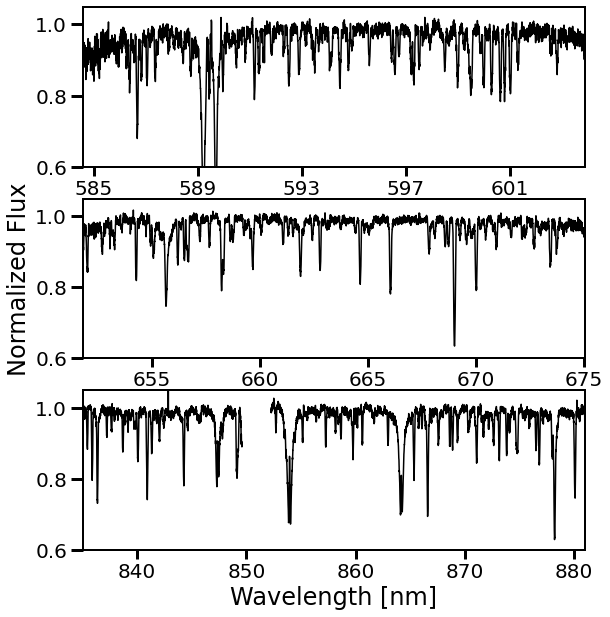

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(9,10),
                                    sharey=True)

hind = 20
ax2.plot(wavelengths['halpha'][hind], spectra['halpha'][hind], 'k')
ax2.set_xlim(wavelengths['halpha'][hind][10], wavelengths['halpha'][hind][-10])

ax3.plot(wavelengths['caII'][15][10:], spectra['caII'][15][10:], 'k')

ax3.plot(wavelengths['caI'][15], spectra['caI'][15], 'k')
ax3.set_xlim(835,881)


nind = 51
q = spectra['NaD'][nind] < 1.02
ax1.plot(wavelengths['NaD'][nind][q], spectra['NaD'][nind][q], 'k')
ax1.set_xlim(wavelengths['NaD'][nind][10], wavelengths['NaD'][nind][-10])
ax1.set_xticks(np.arange(585, 603, 4))

plt.ylim(0.6,1.05)
plt.subplots_adjust(wspace=0.1)

ax2.set_ylabel('Normalized Flux', fontsize=24)
ax3.set_xlabel('Wavelength [nm]', fontsize=24)

plt.savefig(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/',
                         'example_spectra.pdf'), 
            rasterize=True, bbox_inches='tight',
            dpi=300)

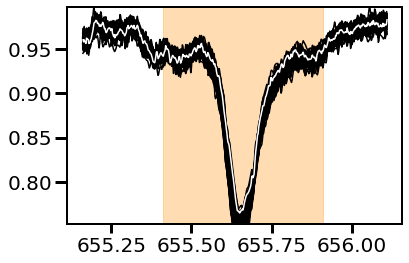

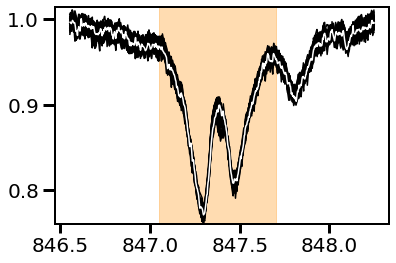

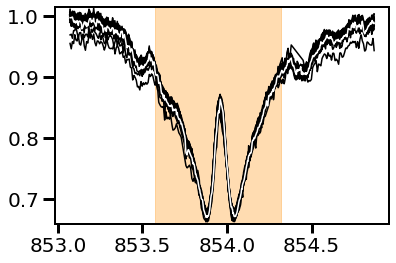

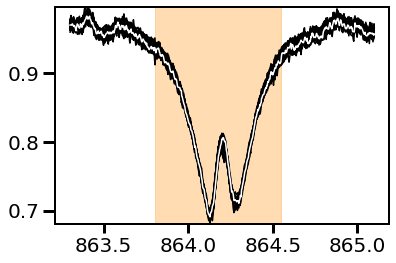

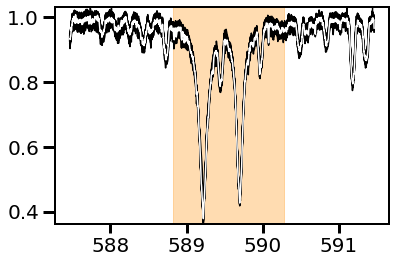

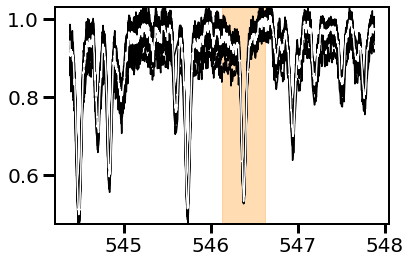

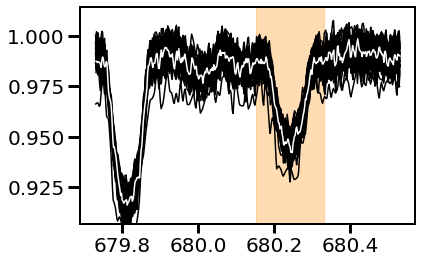

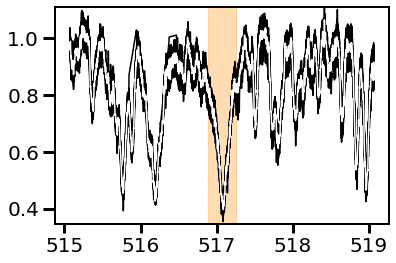

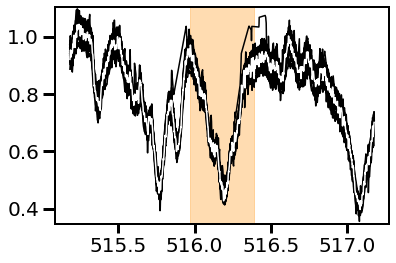

In [12]:
l = 3
offsets = [[0.55,0.4], 
           [0.85,0.85], [0.9,0.9], [0.9,0.9],
           [2,2], 
           [2,1.5], [0.5,0.3], [2,2],
           [1,1], [1,1]]

line_offsets = [[0.3,0.2], 
                [0.35,0.3], [0.4,0.35], [0.4,0.35],
                [0.65,0.82], 
                [0.25,0.25], [0.08,0.1], [0.18,0.18],
                [0.21,0.21], [0.1,0.1]]
widths = {}
ind_lines = {}
ind_waves = {}

for l in range(len(lines)):
    key = lines['line'][l]
    params = subregions(lines['wavelength'][l], 
                        wavelengths[key][0],
                        offsets[l], 
                        line_offsets[l], 
                        feature=key)

    w, il, iw = measure_excess(wavelengths[key], spectra[key], 
                               params, lines[l])

    widths[lines['line'][l]] = w
    ind_lines[lines['line'][l]] = il
    ind_waves[lines['line'][l]] = iw

In [13]:
ind_waves['halpha'].shape, ind_lines['halpha'].shape

((53, 277), (53, 277))

(58870.215, 58870.483)

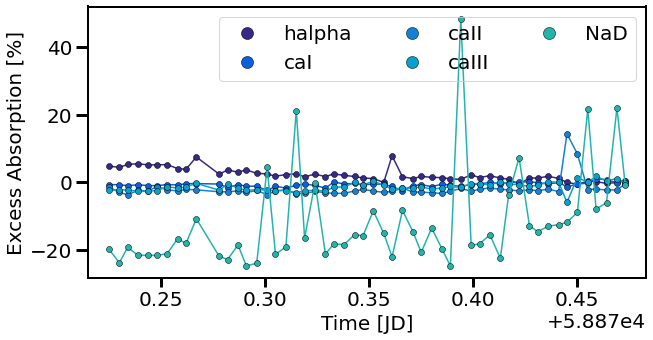

In [83]:
lw = 1.5

plt.figure(figsize=(10,5))

for i, key in enumerate(list(widths.keys())[:5]):
    plt.plot(TIME.value, widths[key], c=parula_colors[i*30], lw=lw)
    plt.plot(TIME.value, widths[key], 'o', c=parula_colors[i*30], 
             markeredgecolor='k', markeredgewidth=0.5, label=key)

plt.legend(ncol=3)
plt.ylabel('Excess Absorption [%]', fontsize=20)
plt.xlabel('Time [JD]', fontsize=20)
plt.xlim(TIME.value[0]-0.01, TIME.value[-1]+0.01)
#plt.ylim(-4,4)

#plt.savefig(os.path.join(plot_dir, 'line_widths.png'),
#            rasterize=True, bbox_inches='tight', dpi=200)

## Comparing to Veloce

In [63]:
from astropy.table import Column

In [134]:
table = Table.read('/Users/arcticfox/Documents/youngStars/veloce/spectra/updated_log.tab',
                   format='ascii')
table = table[table['overlapping']==0]
ages = np.zeros(len(table))
which_age = [25, 150, 150, 150, 25]
for i,t in enumerate(np.unique(table['TIC'])):
    args = np.where(table['TIC']==t)[0]
    ages[args] = which_age[i]
table.add_column(Column(ages, 'Ages_Myr'))

In [135]:
veloce_times = Time(table['time_mjd'], format='mjd')
len(veloce_times)

164

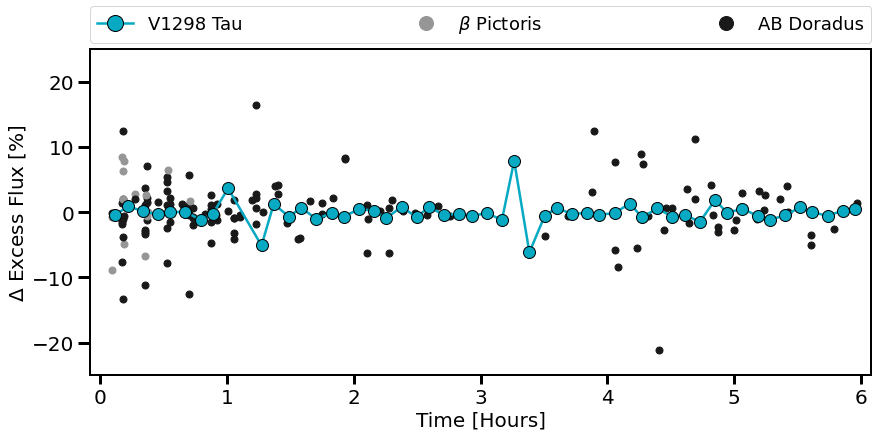

In [209]:
plt.figure(figsize=(14,6))

young_col = colors[6]
older_col = colors[1]

for i, t in enumerate(np.unique(table['TIC'])):
    args = np.where(table['TIC']==t)[0]
    diff = np.diff(veloce_times.value[args])
    brks = np.where(diff>0.2)[0]
    a = np.nanmedian(table['Ages_Myr'][args])
    
    if a == 25:
        c=young_col
        m, ms ='.', 14
    else:
        c=older_col
        m, ms ='.', 14
    
    for d in np.unique(table['Date'][args]):
        dat = table[(table['TIC']==t) & (table['Date']==d)]
        vt  = Time(dat['time_mjd'], format='mjd').value * u.day
        vt  = (vt-vt[0]).to(u.hour)
        
        #plt.plot(vt.value[1:], np.diff(dat['excess']),c=c)
        plt.plot(vt.value[1:], np.diff(dat['excess']),m,c=c,
                 ms=ms)



plt.plot(((TIME-np.nanmin(TIME))*units.day).to(units.hour)[1:], 
         np.diff(widths['halpha']), marker='o',  ms=12, lw=2.5,
         c=parula_colors[100],markeredgecolor='k')


plt.plot(100,100, c=parula_colors[100], label='V1298 Tau', ms=8, marker='o', lw=2.5,
         markeredgecolor='k')
plt.plot(100,100, c=young_col, label=r'$\beta$ Pictoris', ms=ms, marker='.', lw=0)
plt.plot(100,100, c=older_col, label='AB Doradus', ms=ms, marker='.', lw=0)

plt.ylabel('$\Delta$ Excess Flux [%]')
plt.ylim(-25,25)
plt.xlim(-0.08,6.08)
plt.xlabel('Time [Hours]')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., fontsize=18);
plt.savefig(os.path.join(plot_dir, 'veloce_compare.pdf'), dpi=250,
            rasterize=True, bbox_inches='tight')

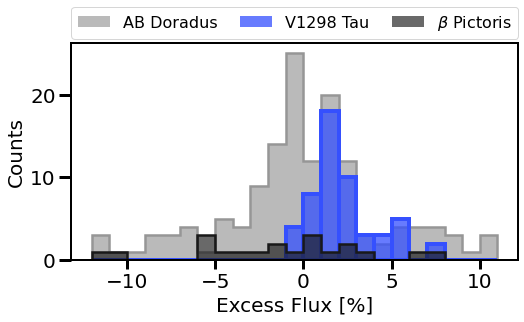

In [649]:
fig, ax = plt.subplots(figsize=(8,4))
bins = np.arange(-12,12,1)
pink = '#c30758'
blue = parula_colors[80]

def plot_hist(ax, dat, bins, c, label, alpha=0.65, lw=2.5, histtype='step'):
    ax.hist(dat, bins=bins,
            color=c, 
            alpha=alpha, label=label)

    ax.hist(dat, bins=bins,
            edgecolor=c, fill=None, histtype=histtype,
            lw=lw)#, label=label)
    return

oc = colors[6]#parula_colors[10]#parula_colors[60]#'#e0db45'
vc = parula_colors[5]
yc = colors[1]#colors[1]#'#f2c708'#'#c30758'#

plot_hist(ax, old_tab['excess'], bins, oc, 'AB Doradus')
plot_hist(ax, widths['halpha'],  bins, '#3550fe', 'V1298 Tau', alpha=0.75,
          histtype='bar', lw=4)
plot_hist(ax, yng_tab['excess'], bins, yc, r'$\beta$ Pictoris')


plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., fontsize=16)
plt.xlabel('Excess Flux [%]')
plt.ylabel('Counts')


plt.savefig('/Users/arcticfox/Desktop/veloce_histogram_grays.png',
            dpi=250, rasterize=True, bbox_inches='tight')

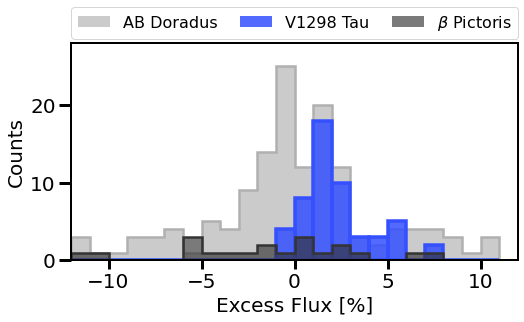

In [648]:
from scipy.stats import norm

xd = np.linspace(-12,12,500)

fig, ax = plt.subplots(figsize=(8,4))

np.random.seed(124)
#density = sum(norm(xi).pdf(xd) for xi in old_tab['excess'])
#plt.fill_between(xd, density,  color=colors[8], label='AB Doradus')
plot_hist(ax, old_tab['excess'],  bins, colors[7], 'AB Doradus', alpha=0.65,
          lw=2.5)

#density = sum(norm(xi).pdf(xd) for xi in widths['halpha'])
#plt.fill_between(xd, density, alpha=0.85, color='#3550fe')#parula_colors[5])
plot_hist(ax, widths['halpha'],  bins, '#3550fe', 'V1298 Tau', alpha=0.85,
          histtype='bar', lw=3.5)

#density = sum(norm(xi).pdf(xd) for xi in yng_tab['excess'])
#plt.fill_between(xd, density,  color=colors[2], zorder=10, label=r'$\beta$ Pictoris')
plot_hist(ax, yng_tab['excess'],  bins, colors[2], r'$\beta$ Pictoris', alpha=0.65,
          lw=2.5)

plt.xlim(-12,12)
plt.ylim(0,28)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., fontsize=16)
plt.xlabel('Excess Flux [%]')
plt.ylabel('Counts')

plt.savefig(os.path.join(plot_dir,'veloce_diff.pdf'), dpi=200,
            rasterize=True, bbox_inches='tight')

In [597]:
parula_colors[220]

'#fec535'

### To-Do List

- **do the same for the veloce data --> measure halpha emission in excess**
- **run elsa's star on one night**
- **run for the rest of the Fraunhofer lines** --> https://en.wikipedia.org/wiki/Fraunhofer_lines
- **e R r O r    B a R s**
    - OPERA pipeline error bars: what do they look like? (✓)
    - Estimate scatter around the line and take that as the uncertainty
- **Cool to do: combine the lines (straightforward in velocity space?)**

### To-Done List

- run for some telluric line and demonstrate we don't see the same thing (✓)
- do the same waterfall plot with just halpha (✓)
- normalize halpha depth to be the same (✓)
    - similar to what we did for veloce emission
- rerun without final 6 frames (✓)
- calcium triplet -- if it's flat we're good. if it isn't we need to fear the spot (✓)

To Trevor, Marshall and cc'ed Ben:
think we see signal in individual lines, but overall, the average line profile is being dominated by stellar activity in a way that's washing everything out. so we don't see anything that's jumping out. so we're leaning towards fraunhofer lines. does that seem like a reasonable approach?

In [17]:
from matplotlib.colors import LinearSegmentedColormap

clist = np.array(['#000000', parula_colors[60], '#FFFFFF',
                  
                  ])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

In [18]:
def expanding_bins(lines, repeat=3, subtract=True):
    global TIME
    
    med = np.nanmedian(lines, axis=0)
    binned = np.zeros( (len(TIME)*repeat, len(lines[0]))  )
            
    z = 0
    for i in range(len(lines)):
        if subtract == True:
            binned[z:z+repeat] = lines[i] - med
        else:
            binned[z:z+repeat] = lines[i]
        z += repeat
    return binned, med

In [20]:
def normalizing_depth(wave, spectra, plot=False, reg=[655.6,655.75]):
    normalized = np.zeros(spectra.shape)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    
    for i,flux in enumerate(spectra):
        
        region = ((wave[i]>=reg[0]) & (wave[i]<=reg[-1]))

        norm_around_zero = flux - np.nanmedian(flux[~region])
        area = np.trapz(norm_around_zero[region], wave[i][region])
        normalized[i] = norm_around_zero/np.abs(area)
        
        if plot:
            ax1.plot(wave[i], flux, c=parula_colors[i*4])
            ax2.plot(wave[i], norm_around_zero / np.abs(area),
                     c=parula_colors[i*4])
            
    if plot:
        plt.show()
    return normalized

In [21]:
halpha_normalized = normalizing_depth(ind_waves['halpha'], ind_lines['halpha'])

In [22]:
def to_velocity(wave, line=None):
    if line != None:
        argmid = np.where(wave>=line)[0][0]
    else:
        argmid = int(len(wave)/2)
    lambda0 = wave[argmid] + 0.0
    rv_m_s = ((wave - lambda0)/lambda0 * 3e8)*units.m/units.s
    rv_km_s = rv_m_s.to(u.km/u.s)
    return rv_km_s, argmid

Text(0, 0.5, 'Normalized Spectra')

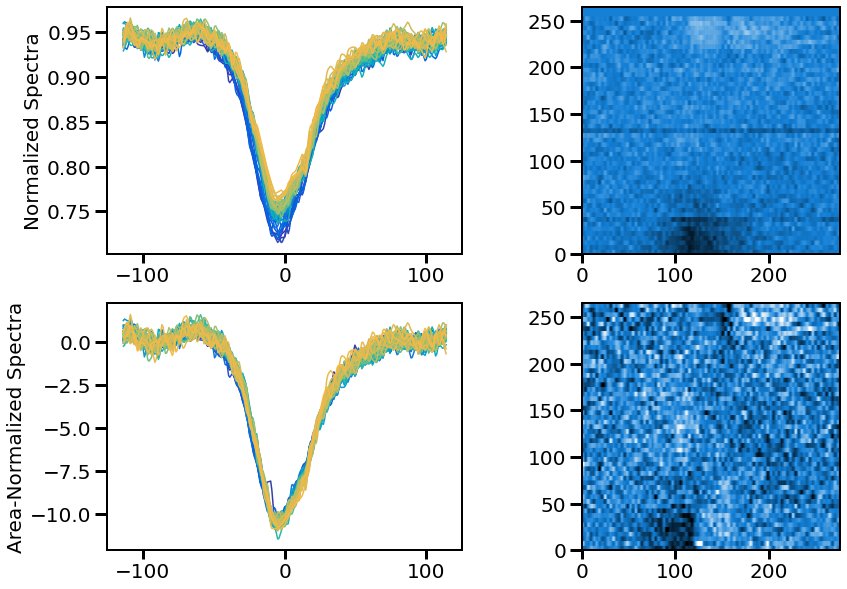

In [23]:
fig, ((ax3, ax1), (ax4, ax2)) = plt.subplots(ncols=2, nrows=2,
                                             figsize=(14,10))
for i in range(2,len(ind_lines['halpha'])):
    vel,_ = to_velocity(ind_waves['halpha'][i])
    
    ax3.plot(vel, ind_lines['halpha'][i], c=parula_colors[i*4])
    ax4.plot(vel, halpha_normalized[i-2], c=parula_colors[i*4])

bins, temp = expanding_bins(ind_lines['halpha'][2:], repeat=5)
ax1.imshow(bins, cmap=cm, vmin=-0.05, vmax=0.05)

bins, temp = expanding_bins(halpha_normalized, repeat=5)
ax2.imshow(bins, cmap=cm, vmin=-1, vmax=1)

ax2.set_ylim(0,len(bins))
ax1.set_ylim(0,len(bins))
ax4.set_ylabel('Area-Normalized Spectra')
ax3.set_ylabel('Normalized Spectra')

#plt.savefig(os.path.join(plot_dir, 'halpha_compare.png'), dpi=200, rasterize=True,
#            bbox_inches='tight')

## Transit model

In [24]:
import batman 

def batman_model(time, vals):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = vals[0]                       #time of inferior conjunction
    params.per = vals[1]                       #orbital period
    params.rp = vals[2]                       #planet radius (in units of stellar radii)
    params.a = vals[3]                        #semi-major axis (in units of stellar radii)
    params.inc = 89.                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [vals[4], vals[5]]     #limb darkening coefficients [u1, u2, u3, u4]

    m = batman.TransitModel(params, time)    #initializes model
    return m.light_curve(params)

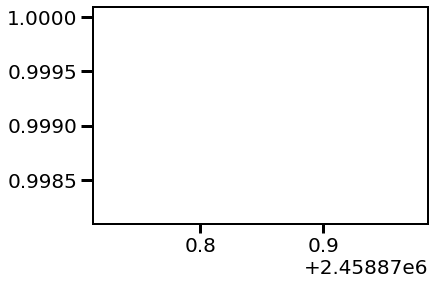

In [25]:
planetc_params_new = [planet_c_t0, 8.24958, 0.0381, 13.19, 0.591, 0.098]
jdtime = Time(TIME, format='mjd').jd
battime = np.linspace(jdtime[0], jdtime[-1], len(jdtime))

c_lightcurve_new = batman_model(battime, planetc_params_new)
plt.plot(battime, c_lightcurve_new, 'wo')
yphase = np.zeros(len(c_lightcurve_new))
yphase[c_lightcurve_new==1.0] = np.nan

args = np.where(np.isnan(yphase)==False)[0]
yphase[args] = np.linspace(0, 1.0, len(args))
#plt.plot(battime, yphase+0.5)

In [26]:
def mask_lines(w, s, std=2.5, offset=0.007, template_inds=None):

    if type(template_inds) == np.ndarray:
        template = np.nanmedian(s[template_inds], axis=0)
    else:
        template = np.nanmedian(s, axis=0)

    newwave = np.zeros((len(w), len(s[0])-1))
    newspectra = np.zeros((len(w), len(s[0])-1))
    
    for i in range(len(w)):
        
        deriv = 0.5*(np.diff(s[i]))
        mask = np.where( (deriv>=offset) | 
                         (deriv<=-offset) )

        masked_w, masked_s = w[i][1:]+0.0, s[i][1:]+0.0
        masked_w[mask] = np.nan
        masked_s[mask] = np.nan
        
        divout = masked_s/template[1:]
        mask = np.where(divout>np.nanmedian(divout)+std*np.nanstd(divout))
        masked_w[mask] = np.nan
        masked_s[mask] = np.nan
       #plt.plot(masked_w[mask], masked_s[mask], 'y.')
        
        newwave[i] = masked_w
        newspectra[i] = masked_s

    return newwave, newspectra

In [187]:
plot_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/figures'

In [31]:
time_to_phase = interp1d(TIME.value, yphase)
phase_to_time = interp1d(yphase, TIME.value)

midtime = phase_to_time(0.5)
halfdur = planet_c_dur / 2.0
t1 = time_to_phase(midtime-halfdur)#, time_to_phase(midtime+halfdur)

ingress_time = (4.66-4.26)/2.0
egress_time = 4.66-ingress_time

interp_time = interp1d(np.linspace(0,4.66,len(yphase[np.isnan(yphase)==False])),
                       yphase[np.isnan(yphase)==False])
ingress_phase = interp_time(ingress_time)
egress_phase = interp_time(egress_time)

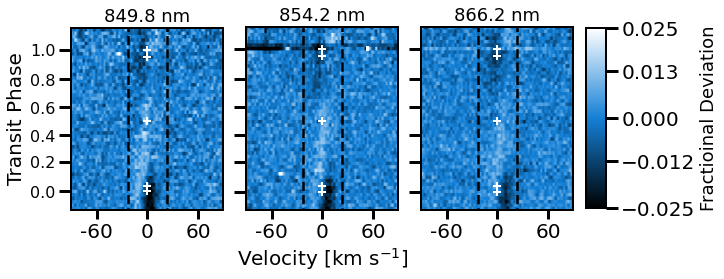

In [34]:
inds = np.arange(0,len(TIME.value)-6,4)

ratio=1.2
repeat = 5
keys = list(ind_lines.keys())[1:4]


fig, axes = plt.subplots(figsize=(9,5),
                         ncols=len(keys), sharey=True,
                         gridspec_kw={'wspace':0.15,
                                      'hspace':0})
cbar_lim = 0.025

i, x = 0, 0
for ax in axes.reshape(-1):
    
    nw, ns = mask_lines(ind_waves[keys[x]], ind_lines[keys[x]], 
                        std=6, offset=0.01,
                        template_inds=np.where(np.isnan(yphase)==True)[0])

    bins, _ = expanding_bins(ns, repeat=repeat)
    
    repeat_phase = np.zeros(len(yphase)*repeat)
    z = 0
    
    for i in range(len(TIME)):
        repeat_phase[z:z+repeat] = yphase[i]
        z += repeat
    interp_phase = interp1d(repeat_phase, np.arange(0,len(repeat_phase),1,dtype=int), )

    vel, midpoint = to_velocity(nw[0])
    vel = vel.value
    interp = interp1d(vel, np.arange(0,len(vel),1))

    ax.set_title(keys[x], fontsize=20)
    #bins = expanding_bins(lines[x], repeat=4)
    im = ax.imshow(bins, cmap=cm,
                   vmin=-cbar_lim, vmax=cbar_lim)

    if x == 1:
        ax.set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)
        ax.set_title('854.2 nm', fontsize=18)
        
    ax.vlines(interp(23), -10, len(bins+30), color='k', lw=2.5, linestyle='--')
    ax.vlines(interp(-23), -10, len(bins)+30, color='k', lw=2.5, linestyle='--')
    
    yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_yticks(interp_phase(yticks))
    ax.set_yticklabels(yticks, fontsize=16)
    
    for p in [0, ingress_phase, 0.5, egress_phase, 1]:
        ax.plot(interp(0), interp_phase(p), 'w+', ms=8, linewidth=2,
                markeredgecolor='w', markeredgewidth=2)
    
    
    ax.set_ylim(0, len(bins))
    
    xticks = [-60,0,60]
    ax.set_xticks(interp(xticks))
    ax.set_xticklabels(xticks)
    ax.set_xlim(interp(-90), interp(90))
    
    if x == 0:
        ax.set_ylabel('Transit Phase', fontsize=20)
        ax.set_title('849.8 nm', fontsize=18)
    if x == 2:
        ax.set_title('866.2 nm', fontsize=18)
    
    x += 1
    
    
cax = fig.add_axes([0.92, 0.255, 0.03, 0.5])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Fractioinal Deviation', fontsize=18)
cbar.set_ticks(np.round(np.linspace(-cbar_lim, cbar_lim, 5),3))
#plt.savefig(os.path.join(plot_dir,
#                         'ca_deviations.pdf'), 
#            rasterize=True, bbox_inches='tight', dpi=250)

In [35]:
np.linspace(-cbar_lim, cbar_lim, 5),2

(array([-0.025 , -0.0125,  0.    ,  0.0125,  0.025 ]), 2)

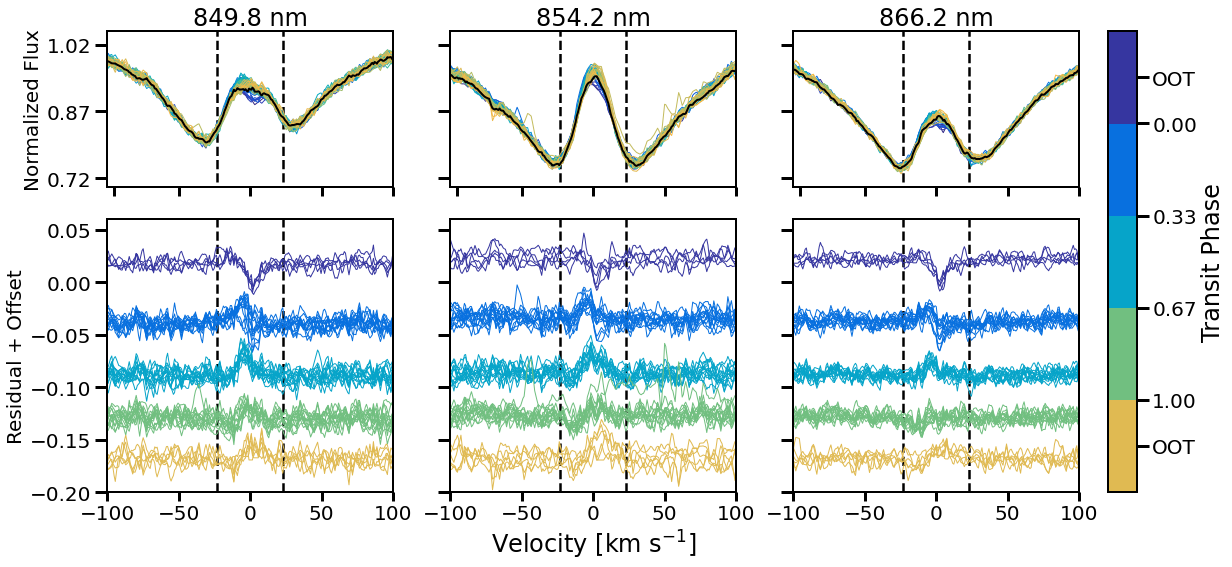

In [36]:
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import BoundaryNorm

subkeys = ['caI', 'caII', 'caIII']
fig, ((ax1, ax2, ax3), (ax4, ax5,ax6)) = plt.subplots(nrows=2, ncols=3,
                                                      figsize=(20,8),
                                                      gridspec_kw={'height_ratios':[1,1.75]})
top_row = [ax1, ax2, ax3]
bottom_row = [ax4, ax5,ax6]

temp_inds = np.where(np.isnan(yphase)==True)[0]

cmap = mpl.colors.ListedColormap(parula_colors)
bounds = [0, 0.3, 0.6, 1.0]
int_bound = []
for i in range(len(bounds)):
    if i == 0:
        ind = np.where((np.isnan(yphase[:10])==True))
    else:
        ind = np.where((yphase>=bounds[i-1]) & (yphase < bounds[i]))
    int_bound.append(int(np.nanmedian(ind)*4))
last_range = np.where(np.isnan(yphase)==True)[0]
last_range = last_range[last_range>10]
int_bound.append( int(np.nanmedian(last_range)*4))
#int_bound.append(int_bound[-1]+2)

#ax0.axis('off')

for k, key in enumerate(subkeys):
    template = np.nanmedian(ind_lines[key][temp_inds], axis=0)
    template /= np.nanmedian(template[:20])

    if key == 'caI':
        l = ind_waves[key][0][145]
    elif key == 'caII':
        l = ind_waves[key][0][165]
    else:
        l = ind_waves[key][0][168]
    vel, midpoint = to_velocity(ind_waves[key][0], line=l)
    
    for i in range(len(ind_lines[key])):
        f = ind_lines[key][i] / np.nanmedian(ind_lines[key][i][:20])

        top_row[k].plot(vel, f, c=parula_colors[i*4], lw=1)
        
        if np.isnan(yphase[i]) == True and i < 10:
            bottom_row[k].plot(vel, f-template+0.02, 
                                c=parula_colors[int_bound[0]], lw=1)
        elif yphase[i]>=0 and yphase[i]<0.33:
             bottom_row[k].plot(vel, f-template-0.04, 
                                c=parula_colors[int_bound[1]], lw=1)
        elif yphase[i]>=0.33 and yphase[i]<0.67:
             bottom_row[k].plot(vel, f-template-0.09, 
                                c=parula_colors[int_bound[2]], lw=1)
        elif yphase[i]>=0.67 and yphase[i]<=1.0:
            bottom_row[k].plot(vel, f-template-0.13, 
                               c=parula_colors[int_bound[3]], lw=1)
        else:
            bottom_row[k].plot(vel, f-template-0.17, 
                               c=parula_colors[int_bound[4]], lw=1)
            
    top_row[k].plot(vel, template, 'k', lw=2)
    
    bottom_row[k].set_xlim(-100,100)
    top_row[k].set_xlim(-100,100)
    
    if k == 0:
        top_row[k].set_title('849.8 nm')
    elif k == 2:
        top_row[k].set_title('866.2 nm')

    top_row[k].set_xticks([-95, -50, 0, 50, 100])
    bottom_row[k].set_xticks([-100, -50, 0, 50, 100])
    
    top_row[k].set_xticklabels([])
    
    top_row[k].vlines(23, -10, 10, color='k', linestyle='--', lw=2.5)
    top_row[k].vlines(-23, -10, 10, color='k', linestyle='--', lw=2.5)
    
    bottom_row[k].vlines(23, -10, 10, color='k', linestyle='--', lw=2.5)
    bottom_row[k].vlines(-23, -10, 10, color='k', linestyle='--', lw=2.5)
    
    if k > 0:
        top_row[k].set_yticklabels([])
        bottom_row[k].set_yticklabels([])
    top_row[k].set_ylim(0.7,1.05)
    top_row[k].set_yticks(np.round(np.linspace(0.72,1.02,3),2))
    bottom_row[k].set_ylim(-0.2,0.06)
    
    if k == 1:
        bottom_row[k].set_xlabel('Velocity [km s$^{-1}$]', fontsize=24)
        top_row[k].set_title('854.2 nm')
bottom_row[0].set_ylabel('Residual + Offset')
top_row[0].set_ylabel('Normalized Flux')

cmap = mpl.colors.ListedColormap(np.flip(parula_colors[int_bound]))
#norm = BoundaryNorm(int_bound, cmap.N)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.82, 0.1, 0.02, 0.8])

cbar = ColorbarBase(cax, cmap=cmap)#, 
                    #norm=norm)
cbar.set_ticks([0.1, 0.2, 0.4, 0.6, 0.8, 0.9])
cbar.set_ticklabels(np.flip(['OOT', '0.00', '0.33', '0.67', '1.00', 'OOT']))
cbar.set_label('Transit Phase', fontsize=24)
plt.subplots_adjust(hspace=0.15, wspace=0.2)
#plt.colorbar(cax=cax)


#plt.savefig(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/',
#                         'calcium_triplet.pdf'), 
#            rasterize=True, bbox_inches='tight', dpi=250)

In [37]:
np.arange(0,1.2,0.2)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

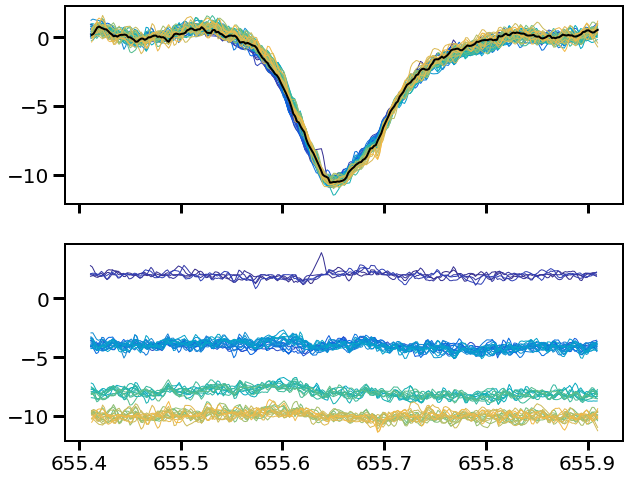

In [38]:
key = 'halpha'
template = np.nanmedian(halpha_normalized[temp_inds], axis=0)
#template /= np.nanmedian(template)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,8), sharex=True)

for i in range(len(halpha_normalized)):
    
    ax1.plot(ind_waves[key][i], halpha_normalized[i], c=parula_colors[i*4], lw=1,
             label=np.round(TIME[i].value,3))
    if i < 5:
        ax2.plot(ind_waves[key][i], halpha_normalized[i]-template+2, 
                 c=parula_colors[i*4], lw=1)
    elif i >= 5 and i <25:
         ax2.plot(ind_waves[key][i], halpha_normalized[i]-template-4, 
                  c=parula_colors[i*4], lw=1)
    elif i >=25 and i < 37:
         ax2.plot(ind_waves[key][i], halpha_normalized[i]-template-8, 
                  c=parula_colors[i*4], lw=1)
    else:
        ax2.plot(ind_waves[key][i], halpha_normalized[i]-template-10, 
                 c=parula_colors[i*4], lw=1)
ax1.plot(ind_waves[key][i], template, 'k', lw=2)
#ax1.set_ylim(0.73,1.1)
#ax2.set_ylim(-0.17,0.07)
#plt.xlim(847.3, 847.5)
#plt.xlim(864., 864.4)


In [435]:
((20*u.km/u.s*857*u.nm)/(3e8*u.m/u.s)).to(u.nm)

<Quantity 0.05713333 nm>

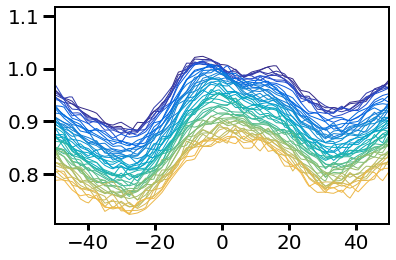

In [769]:
key = 'caI'
for i in range(len(ind_waves[key])):
    vel, _ = to_velocity(ind_waves[key][i])
    f = ind_lines[key][i] / np.nanmedian(ind_lines[key][i])

    plt.plot(vel, f-0.003*i, c=parula_colors[i*4], lw=1)
    plt.xlim(-50,50)

## Measuring RVs

### Marshall's code + RVs

In [307]:
savdir = '/Users/arcticfox/Documents/atmospheres/v1298tau/marshall_plots/planetc'
marshall = readsav(os.path.join(savdir, 'working-dtout.sav'))

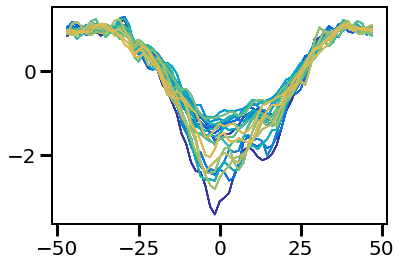

In [308]:
# fit a line to the ends to try and flatten the lines

template = np.nanmedian(marshall['phaseprof'], axis=0)
rvs = np.zeros(len(marshall['phaseprof']))
inds = np.append(np.arange(0,10,1,dtype=int), np.arange(len(marshall['vabsfine'])-10,
                                                        len(marshall['vabsfine']), 1, dtype=int))
for i in range(len(marshall['phaseprof'])):
    fit = np.polyfit(marshall['vabsfine'][inds], 
                     marshall['phaseprof'][i][inds], deg=2)
    model = np.poly1d(fit)
    
    if i < 200:
        plt.plot(marshall['vabsfine'], 
                 marshall['phaseprof'][i]/model(marshall['vabsfine']), 
                 c=parula_colors[i])
    
    rvs[i] = np.nansum( (marshall['phaseprof'][i]-template) * marshall['vabsfine']   )

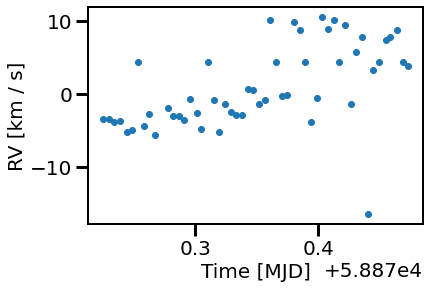

In [309]:
_, args = np.unique(rvs, return_index=True)
args = np.linspace(0, len(rvs)-1, len(TIME), dtype=int)
plt.plot(TIME, rvs[args],'o')
plt.xlabel('Time [MJD]')
plt.ylabel('RV [km / s]');
#plt.savefig(os.path.join(plot_dir, 'marshall_rvs.png'),
#            dpi=200, rasterize=True, bbox_inches='tight')

### My lines --> RVs

In [1176]:
# fit a line to the ends to try and flatten the lines

In [310]:
list(ind_lines.keys())

['halpha', 'caI', 'caII', 'caIII', 'NaD', 'FeII', 'Li', 'mgb2', 'mgb4']

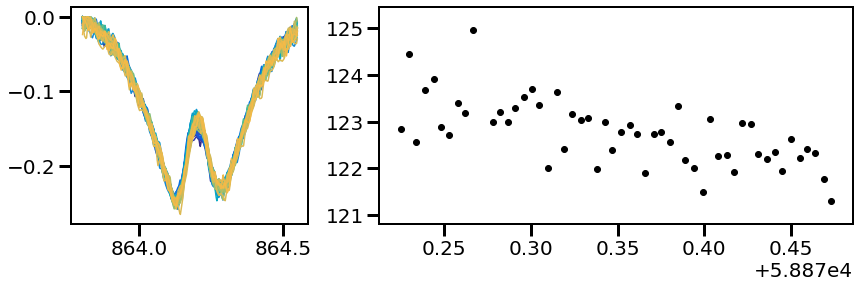

In [313]:
key = 'caIII'

template = np.nanmedian(ind_lines[key], axis=0)

peaks = np.zeros(len(ind_lines[key]))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4),
                               gridspec_kw={'width_ratios':[1,2]})
inds = np.append(np.arange(0,25,1,dtype=int), 
                 np.arange(len(ind_waves[key][0])-25,
                           len(ind_waves[key][0]),1,dtype=int))

fit = np.polyfit(ind_waves[key][0][inds], template[inds], deg=11)
model = np.poly1d(fit)
template /= model(ind_waves[key][0])


for i, flux in enumerate(ind_lines[key]):
    fit = np.polyfit(ind_waves[key][i][inds], flux[inds], deg=11)
    model = np.poly1d(fit)
    model = model(ind_waves[key][i])
    
    corr = np.correlate(template - np.nanmedian(template), 
                        flux/model - np.nanmax(flux/model),
                        mode='same')
    
    ax1.plot(ind_waves[key][i], 
             flux-np.nanmax(flux), c=parula_colors[i*4])
    
    c = np.arange(np.argmax(corr)-4, np.argmax(corr)+5,1,dtype=int)

    
    fit = np.polyfit(c-np.argmax(c), corr[c], deg=2)
    maximum = -fit[1]/(2*fit[0]) # pixel units
    peaks[i] = maximum
    
rvs = np.nanmedian(np.diff(np.log(ind_waves[key][0]))) * 3e8 * peaks
rvs = (rvs * u.m / u.s).to(u.km/u.s)
ax2.plot(TIME, rvs,'ko')
ax2.set_ylim(np.nanmin(rvs.value)-0.5, np.nanmax(rvs.value)+0.5);
#plt.ylim(135,145)

## Error bars

In [42]:
files = np.sort(os.listdir(os.path.join(datadir, 'reduced')))
files = np.sort([os.path.join(os.path.join(datadir, 'reduced'), i) for i in files])

In [43]:
len(files), datadir

(53, '/Users/arcticfox/Downloads/gemini_data')

In [44]:
i = 0
ORDER_START = 23

interp_variances = {}

for j in range(len(lines)):
    key = lines['line'][j]
    
    for i in range(len(files)):
        hdu = fits.open(files[i])
        o = hdu[0].data[0] == ORDER_START+lines['index'][j]

        if i == 0:
            variances = np.zeros((len(files), len(hdu[0].data[11][o])))
        
        try:
            variances[i] = np.sqrt(hdu[0].data[11][o])
        except ValueError:
            variances[i] = np.sqrt(hdu[0].data[11][o][:len(variances[0])])

    iv = np.zeros(wavelengths[key].shape)
        
    for i in range(len(variances)):
        mod = interp1d(hdu[0].data[4][o][:len(variances[0])], variances[i])
        iv[i] = mod(wavelengths[key][i])

    interp_variances[key] = iv
    
    hdu.close()

In [45]:
interp_variances['halpha'].shape

(53, 12774)

In [691]:
# see the variation in the halpha, doesn't match up with the transit
# when we normalize depth. there's only an up-and-down change
# similar magnitude of h-alpha variation we see in veloce data
# probably just consistent with youth

# Feature light curves

In [139]:
keys = list(ind_waves.keys())
keys

['halpha', 'caI', 'caII', 'caIII', 'NaD', 'FeII', 'Li', 'mgb2', 'mgb4']

In [140]:
pieces = {}

for l, key in enumerate(keys[:-1]):
    
    
    params = subregions(lines['wavelength'][l], 
                        wavelengths[key][0],
                        offsets[l], 
                        line_offsets[l], 
                        feature=key)
    
    cont_split = int(np.where(np.diff(params['continuum']) > 1)[0][0])

    red = params['continuum'][cont_split+1:]
    blue = params['continuum'][:cont_split]
    

    for i in range(len(wavelengths[key])):
        
        if i == 0:
            f = np.zeros((len(wavelengths[key]), 
                         len(spectra[key][i][params['region']][params['line']])))
            r = np.zeros((len(wavelengths[key]), len(spectra[key][i][red])))
            b = np.zeros((len(wavelengths[key]), len(spectra[key][i][blue])))
            w = np.zeros((len(wavelengths[key]), 
                         len(interp_variances[key][i][params['region']][params['line']])))
            
        f[i] = spectra[key][i][params['region']][params['line']]+0.0
        w[i] = interp_variances[key][i][params['region']][params['line']]**2
        
        r[i] = spectra[key][i][red] + 0.0
        b[i] = spectra[key][i][blue]+ 0.0
        
        #num_val = feat/weight
        #denom_val = 1.0/weight

    pieces[key] = [f, w, r, b]

In [141]:
list(pieces.keys())

['halpha', 'caI', 'caII', 'caIII', 'NaD', 'FeII', 'Li', 'mgb2']

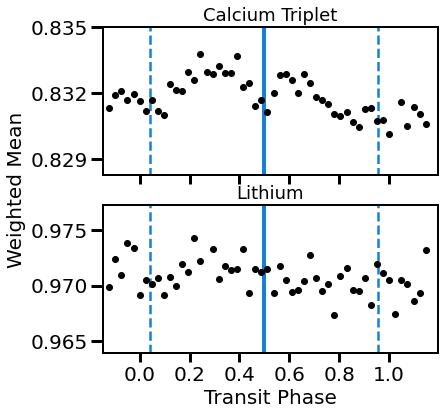

In [142]:
num, denom = 0, 0
cont, err = 0, 0

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6,6),
                               sharex=True)

interp = interp1d(yphase, np.arange(0,len(yphase),1))
for phase in [ingress_phase, egress_phase, 0.5]:
    if phase != 0.5:
        linestyle='--'
        lw=2.5
    else:
        linestyle='-'
        lw=4
    ax1.vlines(interp(phase), -10, 10, lw=lw,
               color=parula_colors[60], linestyle=linestyle)
    ax2.vlines(interp(phase), -10, 10, lw=lw,
               color=parula_colors[60], linestyle=linestyle)

for key in list(pieces.keys())[6:7]:
    num += np.nanmean(np.array(pieces[key][0]), axis=1)/np.nanmean(np.array(pieces[key][1]), axis=1)
    denom += 1.0/np.nanmean(np.array(pieces[key][1]), axis=1)
    err += np.sqrt(1.0/np.nanmean(np.array(pieces[key][1]), axis=1))
    cont += np.nanmean(np.array(pieces[key][2]), axis=1)
    cont += np.nanmean(np.array(pieces[key][3]), axis=1)

flux1 = (num/denom)#/cont
#flux1 /= np.nanmedian(flux1)

#err = np.sqrt(1/np.nansum(interp_variances['Li']**2, axis=1))

ax2.errorbar(np.arange(0,len(flux1),1), flux1, 
             color='k', #yerr=err, 
             fmt='o')

ax2.set_title('Lithium', fontsize=18)
ax2.set_ylim(np.nanmin(flux1)+0.009, np.nanmax(flux1)+0.003)


ax2.set_yticks(np.round(np.arange(np.nanmin(flux1)+0.010, np.nanmax(flux1)+0.003,0.005),3))

num, denom = 0, 0
cont, err = 0, 0

for key in list(pieces.keys())[1:4]:
    num += np.nanmean(np.array(pieces[key][0]), axis=1)/np.nanmean(np.array(pieces[key][1]), axis=1)
    denom += 1.0/np.nanmean(np.array(pieces[key][1]), axis=1)
    err += np.sqrt(1.0/np.nanmean(np.array(pieces[key][1]), axis=1))
    cont += np.nanmean(np.array(pieces[key][2]), axis=1)
    cont += np.nanmean(np.array(pieces[key][3]), axis=1)

flux2 = (num/denom)#/cont
#flux2 /= np.nanmedian(flux2)
ax1.plot(flux2, 'ko')
ax1.set_ylim(np.nanmin(flux2)+0.001, np.nanmax(flux2)+0.001)
ax1.set_yticks(np.round(np.arange(np.nanmin(flux2)+0.002, np.nanmax(flux2)+0.002,0.003),3))
ax1.set_title('Calcium Triplet', fontsize=18)

ax2.set_xlabel('Transit Phase')
ax2.set_ylabel('Weighted Mean', y=1.1)
    

ax2.set_xticks(interp(np.arange(0,1.2,0.2)))
ax2.set_xticklabels(np.round(np.arange(0,1.2,0.2),2))
ax2.set_xlim(-1, len(yphase)+1);

#plt.savefig(os.path.join(plot_dir, 'weighted_means.pdf'),
#            rasterize=True, bbox_inches='tight', dpi=250)

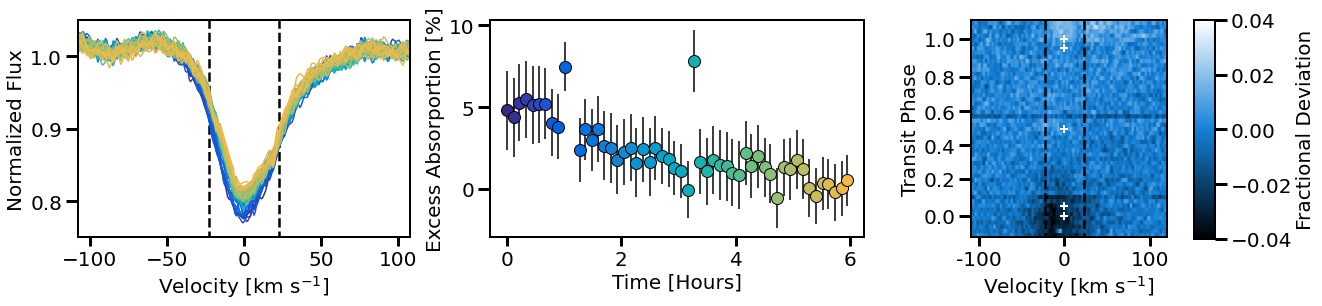

In [52]:
nw, ns = mask_lines(ind_waves['halpha'], ind_lines['halpha'], std=3, offset=0.05)#,
                    #template_inds=np.where(np.isnan(yphase)==True)[0])

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,4),
                                    gridspec_kw={'width_ratios':[2,2.25,1.5]})
time_hours = (TIME.value*units.day-np.nanmin(TIME.value)*units.day).to(units.hour)

vel, midpoint = to_velocity(nw[0], line=655.65)
vel = vel.value

err = 1/np.nansum(interp_variances['halpha']**2, axis=1)

for i in range(len(ns)):
    ax1.plot(vel, ns[i]/np.nanmedian(ns[i]),  c=parula_colors[i*4])
    ax2.errorbar(time_hours.value[i], widths['halpha'][i], 
                 yerr=err[i],
                 marker='o', ms=12, ecolor='k',
                 c=parula_colors[i*4],
                 markeredgecolor='k')

    
ax1.vlines(23, -100, 1000,
           color='k', linestyle='--', lw=2.5)
ax1.vlines(-23, -100, 1000,
           color='k', linestyle='--', lw=2.5)

ax1.set_xlabel('Velocity [km s$^{-1}$]')
ax1.set_ylim(0.75,1.05)
ax1.set_xlim(-108,108)
ax1.set_ylabel('Normalized Flux')


ax2.set_ylabel('Excess Absorportion [%]')
ax2.set_xlabel('Time [Hours]')

repeat=6
bins, temp = expanding_bins(ind_lines['halpha'], repeat=repeat)
im = ax3.imshow(bins, cmap=cm, vmin=-0.04, vmax=0.04)

repeat_yphase = np.zeros(len(yphase)*repeat)

z = 0
for i in range(len(yphase)):
    repeat_yphase[z:z+repeat] = yphase[i]
    z += repeat

interp = interp1d(repeat_yphase, np.arange(0,len(repeat_yphase),1))
yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax3.set_yticks(interp(yticks))
ax3.set_yticklabels(yticks)

interp_vel = interp1d(vel, np.arange(0,len(vel),1))

xticks = [interp_vel(-100), interp_vel(0), interp_vel(100)]
ax3.set_xticks(xticks)
ax3.set_xticklabels([-100,0,100])

for p in [0, ingress_phase, 0.5, egress_phase, 1]:
    ax3.plot(interp_vel(0), interp(p), 'w+', ms=8, linewidth=2,
             markeredgecolor='w', markeredgewidth=2)


ax3.vlines(np.where(vel>=23)[0][0], -100, 1000,
           color='k', linestyle='--', lw=2.5)
ax3.vlines(np.where(vel>=-23)[0][0], -100, 1000,
           color='k', linestyle='--', lw=2.5)
#ax3.hlines(interp(0.5), -100, 1000, color='w',
#           linestyle='--', lw=2.5)


ax3.set_ylim(0,len(bins)-10)
ax3.set_xlim(0, len(bins[0]))
ax3.set_ylabel('Transit Phase', fontsize=20)
ax3.set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)

cax = fig.add_axes([0.9, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Fractional Deviation')

plt.subplots_adjust(wspace=0.25)
#plt.savefig(os.path.join(plot_dir, 'halpha.pdf'),
#            dpi=250, rasterize=True,
#            bbox_inches='tight')

In [620]:
widths['halpha'][0]- widths['halpha'][-1]

4.288673542244151

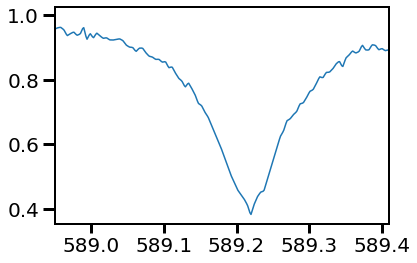

In [170]:
plt.plot(ind_waves['NaD'][0], ind_lines['NaD'][0])
plt.xlim(588.95,589.41)
plt.vlines(589.22,0.4,0.8,color='w')
#plt.xlim(589.45, 589.9)

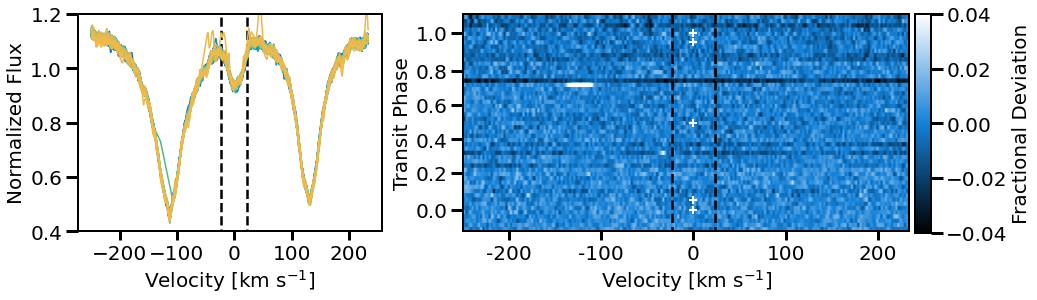

In [164]:
q = ( (ind_waves['NaD'][0]>=588.95) & (ind_waves['NaD'][0]<=589.9))
nw, ns = ind_waves['NaD'][:,q]+0.0, ind_lines['NaD'][:,q]+0.0
#nw, ns = mask_lines(ind_waves['NaD'][:,q], ind_lines['NaD'][:,q], std=3, offset=0.05,#,
#                    template_inds=np.where(np.isnan(yphase)==True)[0])

fig, (ax1,ax3) = plt.subplots(ncols=2, figsize=(15,4),
                                    gridspec_kw={'width_ratios':[1.5,2.25]})
time_hours = (TIME.value*units.day-np.nanmin(TIME.value)*units.day).to(units.hour)

def calc_width(w, f, temp):
    divout = f/template_out
    mask = np.where(divout < np.nanmedian(divout)+2.5*np.nanstd(divout))[0]
    return np.nansum((f[mask]/template_out[mask]) - 1) * -1 

#q = ( (ind_waves['NaD'][0]>=588.95) & (ind_waves['NaD'][0]<=589.41))
#q = ( (ind_waves['NaD'][0]>=588.95) & (ind_waves['NaD'][0]<=589.9))
#nw, ns = ind_waves['NaD'][:,q]+0.0, ind_lines['NaD'][:,q]+0.0

out = np.isnan(yphase)==True
template_out = np.nanmedian(ns[out], axis=0)

vel, midpoint = to_velocity(nw[0], line=589.44)
vel = vel.value

err = 1/np.nansum(interp_variances['NaD']**2, axis=1)

for i in range(len(ns)):
    norm = ns[i]/np.nanmedian(ns[i])
    n = norm<=(1.5*np.nanstd(norm))+np.nanmedian(norm)
    ax1.plot(vel, norm[n],  c=parula_colors[i*4])
    
#    wd = calc_width(nw[i], ns[i], template_out)
#    ax2.errorbar(time_hours.value[i], wd,
#                 yerr=err[i],
#                 marker='o', ms=12, ecolor='k',
#                 c=parula_colors[i*4],
#                 markeredgecolor='k')

    
ax1.vlines(23, -100, 1000,
           color='k', linestyle='--', lw=2.5)
ax1.vlines(-23, -100, 1000,
           color='k', linestyle='--', lw=2.5)

ax1.set_xlabel('Velocity [km s$^{-1}$]')
ax1.set_ylim(0.4,1.2)
#ax1.set_xlim(-108,108)
ax1.set_xticks([-200,-100,0,100,200])
ax1.set_ylabel('Normalized Flux')


#ax2.set_ylabel('Excess Absorportion [%]')
#ax2.set_xlabel('Time [Hours]')

repeat=6
bins, temp = expanding_bins(ns, repeat=repeat)
im = ax3.imshow(bins, cmap=cm, vmin=-0.04, vmax=0.04)

repeat_yphase = np.zeros(len(yphase)*repeat)

z = 0
for i in range(len(yphase)):
    repeat_yphase[z:z+repeat] = yphase[i]
    z += repeat

interp = interp1d(repeat_yphase, np.arange(0,len(repeat_yphase),1))
yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax3.set_yticks(interp(yticks))
ax3.set_yticklabels(yticks)

interp_vel = interp1d(vel, np.arange(0,len(vel),1))

xticks = [interp_vel(-200), interp_vel(-100), interp_vel(0), 
          interp_vel(100), interp_vel(200)]
ax3.set_xticks(xticks)
ax3.set_xticklabels([-200, -100,0,100, 200])

for p in [0, ingress_phase, 0.5, egress_phase, 1]:
    ax3.plot(interp_vel(0), interp(p), 'w+', ms=8, linewidth=2,
             markeredgecolor='w', markeredgewidth=2)


ax3.vlines(np.where(vel>=23)[0][0], -100, 1000,
           color='k', linestyle='--', lw=2.5)
ax3.vlines(np.where(vel>=-23)[0][0], -100, 1000,
           color='k', linestyle='--', lw=2.5)
#ax3.hlines(interp(0.5), -100, 1000, color='w',
#           linestyle='--', lw=2.5)


ax3.set_ylim(0,len(bins)-10)
ax3.set_xlim(0, len(bins[0]))
ax3.set_ylabel('Transit Phase', fontsize=20)
ax3.set_xlabel('Velocity [km s$^{-1}$]', fontsize=20)

cax = fig.add_axes([0.9, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Fractional Deviation')

plt.subplots_adjust(wspace=0.2)

#plt.savefig(os.path.join(plot_dir, 'halpha.pdf'),
#            dpi=250, rasterize=True,
#            bbox_inches='tight')

In [ ]:
# overall spot distribution archival Hubble transmission spectroscopy data?
# think through if we can build a story that explains variation in line core 
#     and variation in calcium depth in terms of spots
#     Paparazzi??